# Raport 2

**Emil Olzewski, 268789**

In [1]:
using Plots
using Distributions
using Statistics
using LaTeXStrings
using LinearAlgebra
using BenchmarkTools
using StatsPlots
using StatsBase

**Uwagi**:
* Ze względu na parametryzację rozkładu wykładniczego w Julii, rozkład $\text{Exp}(\lambda)$ uzyskuje się poprzez `Exponential(1/λ)` tak jak przedstawiono w dokumentacji poniżej.

In [ ]:
?Exponential

## Zadanie 1

**Szum telegraficzny**

In [2]:
# Funkcja generująca jednorodny proces Poissona
function poisson_proc(T::Real, λ::Real)

    times = Float64[]
    t = 0

    while t < T
        Δt = rand(Exponential(1/λ))
        t += Δt
        push!(times, t)
    end

    return (times, 0:length(times)-1)
end

poisson_proc (generic function with 1 method)

In [ ]:
# Wykres trajektorii procesu Poissona
function plot_poisson(traj::Tuple{AbstractVector, AbstractVector}; kwargs...)
   plot(traj[1], traj[2], seriestype=:steppre; kwargs...) 
end

In [ ]:
plot_poisson(poisson_proc(100, 2), title="Jednorodny proces Poissona", label=nothing, xlabel=L"t", ylabel=L"N_t")

In [3]:
# Funkcja generująca proces szumu telegraficznego
function noise(T::Real, λ::Real)

    times, pois = poisson_proc(T, λ)

    # D z rozkładu dwupunktowego P(D=1)=P(D=-1)=1/2
    D = 2rand(Bernoulli(0.5)) - 1

    # Zwraca czasy oczekiwania, wartości procesu i wartość początkową
    return (times, D .* (-1) .^ pois, D)

end

noise (generic function with 1 method)

In [ ]:
# Wykres trajektorii procesu szumu telegraficznego
function plot_noise(T::Real, λ::Real)
    
    times, xs, _ = noise(T, λ)
    
    plot(
        title="Szum telegraficzny",
        xlabel=L"t",
        ylabel=L"X_t",
        legend=nothing
    )

    # plotowanie schodków
    for i in 1:length(times) - 1
        plot!(
            times[i:i+1],
            [xs[i], xs[i]],
            lw=2,
            color=:dodgerblue1,
            label=nothing
        )
    end

    # przedziały domknięte lewostronnie
    scatter!(
        times[1:end-1],
        xs[1:end-1],
        markersize=3,
        color=:dodgerblue1,
        label=nothing
    )

    # otwarte prawostronnie
    scatter!(
        times[2:end],
        xs[1:end-1],
        markersize=3,
        markercolor=:white,
        label=nothing
    )
end

In [ ]:
plot_noise(10, 1)

In [ ]:
# Średnia wartość szumu w czasie t
function noise_expected_value(T::Real, λ::Real, t::Real; num_of_runs::Integer=100)

    accum = 0
    
    for _ in 1:num_of_runs
        
        ts, xs, D = noise(T, λ)
        idx = findfirst(x -> t < x, ts) - 1
        
        accum += idx == 0 ? D : xs[idx] 
    
    end

    return accum/num_of_runs

end

In [ ]:
# Wykres funkcji średniej szumu telegraficznego
function plot_expected_value(T::Real, λ::Real; num_of_runs::Integer=1000, time_step::Real=0.1)
    
    ts = 0:time_step:T
    mt = noise_expected_value.(T, λ, ts; num_of_runs)
    scatter(ts, mt, label="Średnia wartość szumu w czasie t", xlabel="t", ylims=(-0.5,0.5))

end

In [ ]:
plot_expected_value(40, 2)

Kowariancję będziemy estymować ze wzoru
$$\hat{\text{cov}}(X, Y) = \frac{1}{n-1}\,\sum_{i=1}^n \left(X_i - \overline{X}\right)\,\left(Y_i - \overline{Y}\right)$$

In [4]:
# Skorzystamy z faktu, że N(0) = 0, więc X(0) = D
function covariance(T::Real, λ::Real, t::Real; num_of_runs::Integer=100)

    ds = zeros(num_of_runs)
    xts = zeros(num_of_runs)


    for i in 1:num_of_runs
        ts, xs, D = noise(T, λ)
        idx = findfirst(x -> t < x, ts)
        xt = xs[idx]
        ds[i] =  D
        xts[i] = xt
    end


    return sum((ds .- mean(ds)) .* (xts .- mean(xts))) / (num_of_runs - 1)
        

end

covariance (generic function with 1 method)

Użyty estymator kowariancji jest estymatorem nieobciążonym, więc jego wartość srednia zbiega do rzeczywistej wartości kowariancji.

In [5]:
function plot_covariance(T::Real, λ::Real; num_of_runs::Integer=100, time_step::Real=0.1, n::Integer=200)
    
    ts = 0:time_step:T
    covs = zeros(length(ts))

    for _ in 1:n
        covs += covariance.(T, λ, ts; num_of_runs)
    end
    
    scatter(ts, covs./n, label="Kowariancja pomiędzy X(0) i X(t)", xlabel="t")
    plot!(ts, exp.(-2λ .* ts), label="exp(-2λt)") # Współczynniki funkcji wykładniczej zostały dobrane empirycznie.

end

plot_covariance (generic function with 1 method)

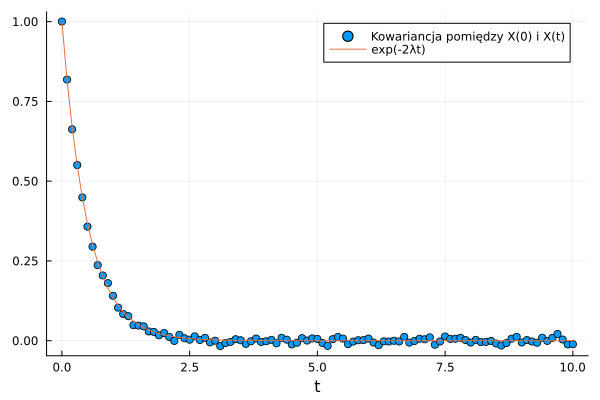

In [6]:
plot_covariance(10, 1)

Jak widać na powyższym wykresie, kowariancja zanika w tempie wykładniczym. Może mieć to związek z wykładniczym rozkładem czasu oczekwiania na pojawienie się pierwszego zgłoszenia w procesie Poissona.

## Zadanie 2

**Efektywność generacji niejednorodnego procesu Poissona**

*Metoda przerzedzania*

In [ ]:
function thinning_method(T::Real, λ::Function, max_λ::Union{Nothing, Real}=nothing; verbose=true)
    
    # Oblicz numerycznie maksimum funkcji λ jeśli nie zostało ono zadane
    if isnothing(max_λ)
       max_λ = maximum(λ, 0:0.01:T)
    end
    
    sum = 0
    result = Float64[]
    count = 0
    accepted = 0
    
    while true
        
        t = rand(Exponential(1/λ(sum)))
        if sum < T
            count += 1
            # Metoda akceptacji-odrzucenia
            if max_λ * rand() <= λ(sum)
                push!(result, sum)
                sum += t
                accepted += 1
            end
        else
            if verbose
                print("Współczynnik akceptacji: $(accepted / count)")
            end
            return (result, 0:length(result)-1)
        end
        
    end
end

Funkcja szybkorosnąca: $\lambda(t) = t + 1$

In [ ]:
plot_poisson(thinning_method(40, x -> x + 1, 41), label="Niejednorodny proces Poissona", xlabel="t", title="Metoda przerzedzania. λ(t) = t + 1")
plot!(0:0.1:40, x -> 1/2 * x^2 + x, label="Górna granica całkowania funkcji λ")

Jak widać trajektoria procesu Poissona asymptotycznie zbiega do górnej granicy całkowania jego funkcji intensywności. Może to być przesłanką za prawidłowym działaniem algorytmu.

In [ ]:
@benchmark thinning_method(10, x -> x + 1, 11; verbose=false)

Funkcja wolnorosnąca: $\lambda(t) = \sqrt{t} + 1$

In [ ]:
plot_poisson(thinning_method(100, x -> sqrt(x) + 1, 11), label="Niejednorodny proces Poissona", xlabel="t", title="Metoda przerzedzania. λ(t)=√t + 1")
plot!(0:0.1:100, x -> 2/3 * x^(3/2) + x, label="Górna granica całkowania funkcji λ")

In [ ]:
@benchmark thinning_method(10, x -> sqrt(x) + 1, sqrt(10) + 1; verbose=false)

Generowanie procesu Poissona metodą przerzedzania jest szybsze przy użyciu wolnorosnącej funkcji $\lambda$. Posiada również większy współczynnik akceptacji niż przy użyciu szybkorosnącej funkcji $\lambda$. 

*Metoda odwrotnej dystrybuanty*

In [ ]:
function inverse_cdf_method(T::Real, mt::Real, invcdf::Function; step=0.01)
    
    N = rand(Poisson(mt))
    times = invcdf.(rand(N))
    return (sort(times), 0:N-1)
    
end

In [ ]:
# λ(t) = t + 1
m(t) = 1/2 * t^2 + t
T = 20

plot_poisson(
    inverse_cdf_method(T, m(T), x -> sqrt(1 + 2*m(T)*x) - 1),
    label="Niejednorodny proces Poissona",
    title="Metoda odwrotnej dystrybuanty. λ(t) = t + 1",
)
plot!(0:0.1:T, m, label="Funkcja górnej granicy całkowania funkcji λ") 

In [ ]:
@benchmark inverse_cdf_method(10, 60, x -> sqrt(1 + 120x) - 1)

Czasy wygenerowania procesu Poissona dla tych samych funkcji $\lambda$ na tym samym przedziale czasowym, metodami przerzedzania i odwrotnej dystrybuanty są porównywalne (W naszym przypadku było to $2.24\, \mu s$ v. $2.09\, \mu s$ dla $T=10$ i $\lambda(t) = t + 1$).

## Zadanie 3

**Estymacja niejednorodnej intensywności**

W celu uzyskania satysfakcjonującej rozdzielczości histogramów będziemy obszar o miarze $|A|$ dzielić na $10\,|A|$ komórek.

In [ ]:
# Histogram dla miary poissonowskiej 1D. 
function one_dim_poisson_measure_hist(measure::Function, args, bins::Integer, num_of_runs=5000; kwargs...)
    
    points = Float64[]
    
    for _ in 1:num_of_runs
       append!(points, measure(args...)) 
    end
    
    # Wagi dobrane w celu unormowania miary pojedynczej komórki.
    histogram(points, bins=bins, weights=10/num_of_runs * ones(length(points)), label="Średnia ilość punktów w danej komórce"; kwargs...) 
    
end

In [ ]:
# Jednorodna miara Poissona określona na prostej, mierząca odcinki [0, l].
function one_dim_poisson_measure(l::Real, λ::Real)
    
    NΩ = rand(Poisson(λ*l))
    result = l * rand(NΩ)
    
    return result 

end

Estymacja w przypadku miary 1D.

In [ ]:
L = 10
one_dim_poisson_measure_hist(one_dim_poisson_measure, [L, 2], 10L; title="Estymacja jednorodnej funkcji intensywności", xlabel="Mierzony odcinek")
plot!(0:L, x -> 2, label="Funkcja intensywności λ", lw=3)

In [ ]:
# Niejednorodna miara Poissona określona na prostej, mierąca odcinki [0, l]
function one_dim_nh_poisson_measure(l::Real, λ::Function, λ_max::Real)
    
    if isnothing(λ_max)
        λ_max = maximum(λ, 0:0.1:l)
    end
    
    NΩ = rand(Poisson(λ_max*l))
    points = l * rand(NΩ)
        
    # Przerzedzanie
    filter!(x -> λ_max * rand() <= λ(x), points)
    
    return points 
        
end

In [ ]:
one_dim_poisson_measure_hist(one_dim_nh_poisson_measure, [L, x -> 2x + 1, 2L + 1], 10L; title="Estymacja niejednorodnej funkcji intensywności", xlabel="Mierzony odcinek")
plot!(0:L, x -> 2x + 1, label="Funkcja intensywności λ", lw=3)

W przypadku miary określonej na płaszczyźnie będziemy dzielić obszar na $25|A|$ komórek. (Ze względu na charakter parametru `bins` w funkcji `histogram2d` chcemy, żeby ten współczynnik był kwadratem liczby naturalnej). 

In [ ]:
# Histogram dla miary poissonowskiej 2D. 
function two_dim_poisson_measure_hist(measure::Function, args, bins::Integer, num_of_runs::Integer=1000; kwargs...)
    
    results = Vector{Matrix{Float64}}(undef, num_of_runs)
    
    for i in 1:num_of_runs
        results[i] = measure(args...)
    end
    
    points = reduce(vcat, results)
    
    # Wagi dobrane w celu unormowania miary pojedynczej komórki.
    histogram2d(eachcol(points)..., bins=bins, weights=25/num_of_runs * ones(size(points, 1)), aspect_ratio=:equal, colorbar_title="Średnia ilośc punktów w danej komórce"; kwargs...)
    
end

In [ ]:
# Jednorodna miara Poissona określona na płaszczyźnie, mierząca koła o środku w (0, 0) i promieniu r. 
function two_dim_poisson_measure(r::Real, λ::Real)
    omega_measure = π * r^2
    NΩ = rand(Poisson(λ * omega_measure))

    points = zeros(NΩ, 2)


    for i in 1:NΩ

        x = 2r * rand() - r
        y = 2r * rand() - r

        while x^2 + y^2 > r^2
            x = 2r * rand() - r
            y = 2r * rand() - r
        end

        points[i, 1] = x
        points[i, 2] = y
    end
    
    return points

end

Estymacja w przypadku miary 2D.

In [ ]:
r = 10
lambda = 2
# Jeśli za argument `bins` funkcji `histogram2d` podamy x, to tyle komórek zostanie utworzonych
# na każdej osi, co daje nam w sumie x^2 komórek. Chcemy mieć w mierzonym kole mniej więcej 25*πr^2 
# komórek, więc w całym kwadracie chcemy 100*r^2, dlatego za `bins` dajemy 10*r. 
bins = 10r
two_dim_poisson_measure_hist(two_dim_poisson_measure, [r, lambda], bins, title="Estymacja jednorodnej funkcji intensywności")

Powyższy histogram odpowiada wykresowi funkcji intensywności $\lambda(t) = 2$.

In [ ]:
# Niejednorodna miara Poissona określona na płaszczyźnie, mierząca koła o środku w (0, 0) i promieniu r. 
function two_dim_nh_poisson_measure(r::Real, λ::Function, λ_max::Real)
   
    points = two_dim_poisson_measure(r, λ_max)
    
    # Przerzedzanie
    result = points[λ_max .* rand(size(points, 1)) .<= λ.(points[:,1], points[:,2]),:]
    
    return result
end

In [ ]:
λ_max = 4
λ1(x, y) = λ_max/(x^2 + y^2 + 1)
r = 10
bins = 10r

two_dim_poisson_measure_hist(two_dim_nh_poisson_measure, [r, λ1, λ_max], bins, title="Estymacja niejednorodnej funkcji intensywności λ₁")

Powyższy histogram odpowiada wykresowi funkcji intensywności $\lambda_1(\mathbf{x}) = \frac{\lambda_{max}}{|\mathbf{x}|^2 + 1}$


In [ ]:
surface(-10:0.1:10, -10:0.1:10, λ1, title="Wykres funkcji intensywności λ₁")

In [ ]:
λ2(x, y) = λ_max/(x^2 + 1)
two_dim_poisson_measure_hist(two_dim_nh_poisson_measure, [r, λ2, λ_max], bins, title="Estymacja niejednorodnej funkcji intensywności λ₂")

Powyższy histogram odpowiada wykresowi funkcji intensywności $\lambda_2(x, y) = \frac{\lambda_{max}}{x^2 + 1}$.

In [ ]:
surface(-10:0.1:10, -10:0.1:10, λ2, title="Wykres funkcji intensywności λ₂")

In [ ]:
λ3(x, y) = λ_max/(abs(x) + abs(y) + 1)
two_dim_poisson_measure_hist(two_dim_nh_poisson_measure, [r, λ3, λ_max], bins, title="Estymacja niejednorodnej funkcji intensywności λ₃")

Powyższy histogram odpowiada wykresowi funkcji intensywności $\lambda_3(x, y) = \frac{\lambda_{max}}{|x| + |y| + 1}$.

In [ ]:
surface(-10:0.1:10, -10:0.1:10, (x, y) -> λ_max/(abs(x) + abs(y) + 1), title="Wykres funkcji intensywności λ₃")

W przypadku niejednorodnej miary Poissona mamy warunek
$$N(A) \sim \text{Poiss}\left(\int_A \lambda(x) dx\right)$$
Wagi w funkcji `histogram2d` zostały dobrane w taki sposób, jakby komórka miała miarę 1, tym samym z tw. o wartości średniej
$$\int_A \lambda(x)\, dx = \overline{\lambda_A}(x)\,|A| = \overline{\lambda_A}(x)$$
gdzie $\overline{\lambda_A}(x)$ oznacza średnią wartość funkcji intensywności na komórce $A$. Ze względu na małe rozmiary komórek i małą zmienność przyjętych w symulacjach funkcji $\lambda$ możemy $\overline{\lambda}$ przybliżać przez dowolną wartość $\lambda$ na komórce. Korzystając dodatkowo z faktu, że wartość oczekiwana zmiennej losowej z rozkładu $\text{Poiss}(\lambda)$ jest równa $\lambda$ stwierdzamy, że histogramy powinny w przybliżeniu odpowiadać wykresom funkcji $\lambda$. Tak też się dzieje w przypadku wykonanych w tym zadaniu symulacji.

## Zadanie 4

**Prawdopodobieństwo ruiny**

In [ ]:
# Generowanie procesu Poissona
function poiss_proc(T::Real, λ::Real)
    
    sum = 0 
    result = Float64[] 
    while true
            sum += rand(Exponential(1/λ))
            if sum < T
                push!(result, sum)
            else 
                return (result, 0:length(result) - 1) 
            end
    end

end

In [ ]:
# Generowanie procesu ryzyka o szkodach z rozkładu d, początkowym kapitale u, oraz dryfie c
function risk_proc(T::Real, λ::Real, d::Distribution, u::Real, c::Real)
    
    # Momenty, w których dochodzi do szkody
    time_intervals, _ = poiss_proc(T, λ)
    # Szkody z rozkładu d
    damages = rand(d, length(time_intervals))

    # Przedział czasowy, na którym modelujemy kapitał
    ts = 0:0.1:T
    # Indeksy momentów szkód w ts
    idx = findfirst.([[t < t0 for t0 in ts] for t in time_intervals])
    # Stałe przychody
    incomes = collect(c .* ts)

    # Odjęcie szkód od przychodów 
    for (i, j) in enumerate(idx) 
        incomes[j:end] .-= damages[i]
    end

    capital = u .+ incomes

    return (collect(ts), capital)
end

In [ ]:
# Wykres trajektorii procesu ryzyka
function plot_risk_trajectory(T::Real, λ::Real, d::Distribution, u::Real, c::Real)

    ts, capital = risk_proc(T, λ, d, u, c)

    plot(
        ts, 
        capital,
        title="Proces Ryzyka: u=$u, c=$c",
        xlabel="t",
        ylabel="Kapitał",
        legend=nothing
    )

end

In [ ]:
plot_risk_trajectory(20, 1, Exponential(1), 3, 1)

Jeśli przez $\tau$ oznaczymy zmienną losową określającą pierwszy moment, w którym kapitał w procesie ryzyka spadnie poniżej 0, to prawdopodbieństwo ruiny w czasie $t$ można zapisać jako $\mathbf{P}(\tau \le t)$. Oznacza to, że oszacowanie prawdopodbieństwa ruiny w czasie $t$ sprowadza się do obliczenia wartości dystrybuanty empirycznej próby zmiennych $\tau$ w tym punkcie.

In [ ]:
# Wygenerowanie próby losowej zmiennych τ
function get_tau_sample(T::Real, λ::Real, d::Distribution, u::Real, c::Real; sample_size::Integer=100)
   
    taus = zeros(sample_size)
    
    for i in 1:sample_size
        
        ts, capital = risk_proc(T::Real, λ::Real, d::Distribution, u::Real, c::Real)
        # Moment w którym pierwszy raz kapitał spada poniżej 0
        bankrupcy_idx = findfirst(x -> x < 0, capital)
        # W przypadku gdy nie doszło do ruiny w rozpatrywanym przez nas przedziale czasowym
        # za τ dajemy T, tym samym interpretowanie wyników będzie miało sens tylko w przyadku t < T. 
        taus[i] = isnothing(bankrupcy_idx) ? T : ts[bankrupcy_idx]
        
    end
    
    return taus
end

In [ ]:
# Wykres dystrybuanty empirycznej
function plot_tau_ecdf(T::Real, λ::Real, d::Distribution, u::Real, c::Real; sample_size::Integer=100)
   
    sample = get_tau_sample(T, λ, d, u, c; sample_size)
    ecdfplot(sample, xlabel="t", ylabel="Prawdopodobieństwo ruiny do czasu t", title="Kapitał początkowy: $u \nDryf: $c", label=nothing, ylims=(0, 1))
    
end

In [ ]:
plot_tau_ecdf(100, 1, Exponential(1), 3, 0.7)

Zwiększając rozmiar losowanej próby zmiennych $\tau$ jesteśmy w stanie zwiększyć dokładność z jaką szacujemy prawdopodobieństwo zajścia ruiny. Poniżej ten sam wykres z 10-krotnie większą próbą.

In [ ]:
plot_tau_ecdf(100, 1, Exponential(1), 3, 0.7; sample_size=1000)

## Zadanie 5

**Rozkład stacjonarny Łańcucha Markowa**

In [ ]:
# Macierz przejścia łańcucha
transition_matrix = [0.5 0.5 0; 0 0.5 0.5; 0.5 0 0.5]

In [ ]:
# Trajektoria łańcucha Markowa
function markov_chain_traj(start, steps::Integer)
         
    trajectory = zeros(Int, steps)
    trajectory[1] = start

    for i in 2:steps

        # Aktualny stan
        current = trajectory[i - 1]

        # Przejście w kolejny stan 
        next = findfirst(isequal(1), rand(Multinomial(1, transition_matrix[current, :])))
        trajectory[i] = next
        
    end
    
    return trajectory
end

Poniżej przedstawiona została przykładowa trajektoria łańcucha Markowa o zdefiniowanej wyżej macierzy przejścia.

In [ ]:
traj = markov_chain_traj(1, 20)
scatter(1:length(traj), traj, label=nothing, title="Trajektoria łańcucha Markowa", xticks=1:length(traj), yticks=1:3)

In [ ]:
# Estymacja rozkładu stacjonarnego. Rozkład stanów łańcuhca w czasie `time`. 
function stationary_dist(time::Integer; num_of_runs::Integer=1000)
        
    final_states = zeros(num_of_runs, 3)
    
    for start_state in 1:3
        for i in 1:num_of_runs
            trajectory = markov_chain_traj(start_state, time)
            final_states[i, start_state] = trajectory[end]
        end
    end
    
    histogram(
        final_states,
        normalize=:probability,
        label=nothing,
        title=["Stan początkowy: $i" for j in 1:1, i in 1:3],
        xticks=1:3,
        layout=@layout grid(3, 1)
    )
end

Stan stacjonarny łańcucha

In [ ]:
stationary_dist(1000)

**Rozkładem stacjonarnym** łańcucha Markowa o macierzy przejścia $\mathbf{P}$ nazywamy taki wektor $\mathbf{\pi}$, że 
$$ \mathbf{\pi}\,\mathbf{P} = \mathbf{\pi}$$
oraz $\sum \mathbf{\pi} = 1$

Rozkład stacjonarny możemy znaleźć korzystając z wektrów własnych macierzy przejścia.

In [ ]:
eigen(transition_matrix)

In [ ]:
eigvec = real.(eigvecs(transition_matrix)[:, 3])
println("Rozkład stacjonarny: ")
eigvec ./ sum(eigvec)

Jak widać wyznaczony powyżej rozkład stacjonarny odpowiada temu otrzymanemu numerycznie.

## Zadanie 6

**Czas wyjścia**

Dwuwymiarowy ruch Browna definiujemy jako 
$$\mathbf{W} = \left(\mathbf{W_1}, \mathbf{W_2}\right)$$
gdzie $\mathbf{W_1}$ i $\mathbf{W_2}$ są niezależnymi od siebie, jednowymiarowymi procesami Wienera.

Do wygenerowania procesu Wienera wykorzystamy fakt, że 
* $W_0 = 0$
* Proces Wienera ma przyrosty niezależne.
* $W_t - W_s \sim N(0, t - s)$
* Proces Wienera ma ciągłą trajektorię.

In [ ]:
# Dwuwymiarowy ruch Browna
function brown(times::AbstractVector)

    Δts = diff(times)
    pushfirst!(Δts, times[1])

    incs = randn(length(times), 2) .* sqrt.(Δts) # Przyrosty z rozkładu N(0, Δt)

    return cumsum(incs, dims=1)

end

In [ ]:
# Wykres trajektorii dwuwymiarowego ruchu Browna
function plot_brown(times::AbstractVector; kwargs...)
        
    traj = brown(times)
    plot(traj[:,1], traj[:,2]; kwargs..., aspect_ratio=1)
    scatter!([0], [0], markersize=3, color=:red, label="Punkt początkowy")
    
end

In [ ]:
plot_brown(0:0.01:10, label="Trajektoria ruchu Browna", title="Dwuwymiarowy ruch Browna")

In [ ]:
# Moment wyjścia ruchu Browna z koła jednostkowego
function first_passage_time(times::AbstractVector)
    
    Δts = diff(times)
    pushfirst!(Δts, 0)
    x = y = 0
    
    for (t, Δt) in zip(times, Δts)
        if x^2 + y^2 > 1
            return t
        end
        x += randn() * sqrt(Δt)
        y += randn() * sqrt(Δt)
    end
    
    error("Proces nie opuścił koła jednostkowego w zadanym przedziale czasowym")
    
end

In [ ]:
# Rozkład momentów wyjścia ruchu Browna.
function first_passage_time_dist(times::AbstractVector; num_of_runs::Integer=1000)
    fp_times = zeros(num_of_runs)
    for i in 1:num_of_runs
        fp_times[i] = first_passage_time(times)
    end
    histogram(fp_times, normalize=:pdf, label="Rozkład czasu wyjścia z koła jednostkowego", xlabel="Czas wyjścia")
end

In [ ]:
first_passage_time_dist(0:0.001:10; num_of_runs=10_000)

Rozkład czasu wyjścia dla jednowymiarowego ruchu Browna jest rozkładem $\frac{1}{2}$-stabilnym, czyli rozkładem Levy'ego. W przypadku dwuwymiarowym rozkład ten nie posiada znanej analitycznej postaci. Możemy jednak przeprowadzić analizę tego rozkładu na podstawie wyniku symulacji. 

In [ ]:
fp_times = zeros(10_000)
for i in 1:10_000
    fp_times[i] = first_passage_time(0:0.001:10)
end

println("Najwcześniejszy czas wyjścia:          $(minimum(fp_times))")
println("Najpóźniejszy czas wyjścia:            $(maximum(fp_times))")
println("Średni czas wyjścia:                   $(round(mean(fp_times), digits=3))")
println("Odchylenie standardowe czasu wyjścia:  $(round(std(fp_times), digits=3))")
println("Pierwszy kwartyl czasu wyjścia:        $(quantile(fp_times, 0.25))")
println("Drugi kwartyl (mediana) czasu wyjścia: $(quantile(fp_times, 0.5))")
println("Trzeci kwartyl czasu wyjścia:          $(quantile(fp_times, 0.75))")

boxplot(fp_times, title="Wykres pudełkowy rozkładu czasu wyjścia", label=nothing, orientation=:h)